In [10]:
import os.path

import torch
import torchvision
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [11]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

real_data = torchvision.datasets.MNIST(
    root='data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

In [12]:
bs = 32
real_dataloader = DataLoader(
    dataset=real_data,
    batch_size=bs
)

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=100, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=28*28),
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.network(X)

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.network(X)

In [15]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

G = Generator()
D = Discriminator()

G.to(device)
D.to(device)

Discriminator(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [16]:
optimizer_G = torch.optim.Adam(G.parameters(), lr=2e-4)
optimizer_D = torch.optim.Adam(D.parameters(), lr=2e-4)

bce_loss = torch.nn.BCELoss()
epochs = 200

In [17]:
loss_D_list = []
loss_G_list = []
iter = 0

def train():
    for epoch in range(epochs):
        print(f"epoch {epoch+1}\n-----------------")
        for i, (X_real, _) in enumerate(real_dataloader):

            y_real = torch.ones(bs, 1)
            y_fake = torch.zeros(bs, 1)

            X_real, y_real, y_fake = X_real.to(device), y_real.to(device), y_fake.to(device)

            # 1 ------------更新Discriminator--------------

            z_batch = torch.randn(bs, 100).to(device)
            X_fake = G(z_batch)

            output_real = D(X_real.reshape(bs, 28*28))
            loss_real = bce_loss(output_real, y_real)
            output_fake = D(X_fake)
            loss_fake = bce_loss(output_fake, y_fake)

            loss_D = loss_real + loss_fake

            D.zero_grad()
            loss_D.backward()
            optimizer_D.step()

            # 2 -------------更新Generator---------------

            z_batch = torch.randn(bs, 100).to(device)
            X_fake = G(z_batch)
            fake_output = D(X_fake)
            loss_G = bce_loss(fake_output, y_real)

            G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

            if i % 100 == 0:
                print(f"loss_G: {loss_G.item()}, loss_D: {loss_D.item()}")
                loss_G_list.append(loss_G.item())
                loss_D_list.append(loss_D.item())
                global iter
                iter += 1
        # 保存最后的权重文件
        torch.save(G.state_dict(), 'model_G.pth')

epoch 1
-----------------
loss_G: 0.7437930107116699, loss_D: 1.4041751623153687
loss_G: 1.6069667339324951, loss_D: 0.8948205709457397
loss_G: 1.8261325359344482, loss_D: 0.5030167698860168
loss_G: 2.2854251861572266, loss_D: 0.425880491733551
loss_G: 2.1251864433288574, loss_D: 0.4780810475349426
loss_G: 2.301460027694702, loss_D: 0.4066917896270752
loss_G: 3.3187308311462402, loss_D: 0.2452307641506195
loss_G: 3.321528434753418, loss_D: 0.12191134691238403
loss_G: 2.833151340484619, loss_D: 0.3641952872276306
loss_G: 3.7215495109558105, loss_D: 0.08459644019603729
loss_G: 4.1698408126831055, loss_D: 0.0494261160492897
loss_G: 3.067568778991699, loss_D: 0.28047817945480347
loss_G: 3.954728364944458, loss_D: 0.0626169741153717
loss_G: 3.467649459838867, loss_D: 0.1289955973625183
loss_G: 4.157444000244141, loss_D: 0.06167490780353546
loss_G: 3.7914340496063232, loss_D: 0.09760123491287231
loss_G: 2.824505090713501, loss_D: 0.2186087667942047
loss_G: 2.3072776794433594, loss_D: 0.48587

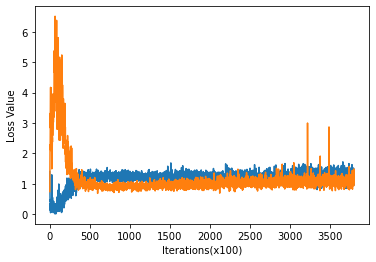

In [18]:
if os.path.exists('model_G.pth'):
    G.load_state_dict(torch.load('model_G.pth'))
else:
    train()

    # 绘制损失图像
    plt.figure()
    plt.plot(range(1, iter+1), loss_D_list)
    plt.plot(range(1, iter+1), loss_G_list)
    plt.xlabel('Iterations(x100)')
    plt.ylabel('Loss Value')

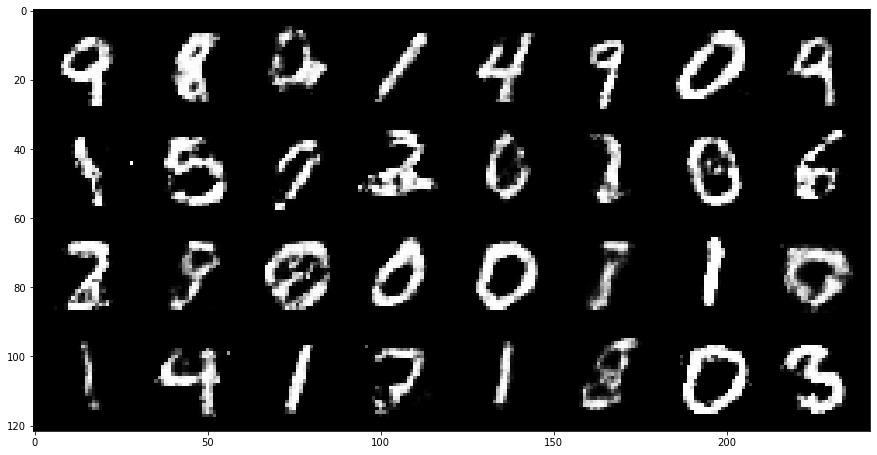

In [39]:
z = torch.randn(bs, 100).to(device)
fake_images = G(z).reshape(bs, 1, 28, 28).cpu().detach()
image_grid = torchvision.utils.make_grid(fake_images)
plt.figure(figsize=(15, 10))
plt.imshow(np.transpose(image_grid, (1, 2, 0)), cmap='gray')